# Environment setup 


## Installing CLIP and YoloV5 and Imports

It the first section of this file, the installation of the needed components is performed. These first bash lines install CLIP and YoloV5 respectively. These two Neural Network will represent the ground base of the project development.

In [1]:
%%capture
%%bash
# Download CLIP and YOLO
pip install git+https://github.com/openai/CLIP.git
pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

# Command to install some needed dependencies in the AWS machine
sudo apt-get update && sudo apt-get install ffmpeg libsm6 libxext6 -y

## List of imports

In [1]:
# general imports
import pickle
import json
import tarfile
import os
import torch
import clip
from PIL import Image, ImageDraw

# utility libraries imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

# torch imports
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms

## Setting the Clip model and Yolo model variables

In [2]:
# Chosing the device 
device = "cuda" if torch.cuda.is_available() else "cpu"

# choosing the clip model and the yolo versions, both pre-trained
clip_model, preprocess = clip.load('RN50', device)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/sagemaker-user/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-17 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# Fine-tuning Clip

## Creation of the train and validation splits

The following code sections contain the needed structures to load the data from the refcoco dataset.
The structures needed are:
1. a Dataset Class to load the Data
2. a Dataloader instantiation, to be used to split data into batches and that will be used to iterate throiugh for train, validation and test

The purpose of the Refcocog is Referring Expression Grounding, whose goal is to identify an object given a referring example. This is corresponds with the objective of this project.

The dataset is composed of 25799 images, each having an average of 3.7 referring expression. These expression are related to specific objects inside the image. The Ground truth is represented by the bounding boxes.

The set of file composing the dataset are:
 - instances.json which contains all the information about the bunding boxes of each image
   example of instance
 - ref(umd).p which is a serialized file with all the description related to a bounding box and the split it belongs to (train/validation/test)
 - the images directory with all the images

This Dataset class, reads the instances.json and refs(umd).p files, creates an association image_id->image_name and annotation_id -> bounding_boxes to simplify the retrivial of the single element in the getitem() method.\
Moreover, a set of samples is created with all the datase entries, each seample is composed of: image id, annotation id, and the sentence. The oobjective of this structure, besides contaioning all samples for the len() method, is to simplify the implementation of the getitem method.\
The latter takes as input an idx (which is the element currently being processed by the iterator) and return the image cropped to the bounding boxes and the sentence related with that box.

In [3]:
class RefCOCOgDataset(Dataset):
    def __init__(self, transform=None, split='train', device='cuda', crop=False):
        # Load images and transform
        self.image_dir = os.path.join('refcocog', 'images')
        self.transform = transform

        # Define class properties for split and device
        self.split = split
        self.device = device
        self.crop = crop

        # Load data from ref(umd) and instances files
        self.refs = self.load_refs()
        self.instances = self.load_instances()

        # Create efficient lookup dictionaries
        self.image_id_to_filename = {img['id']: img['file_name'] 
                                   for img in self.instances['images']}
        self.ann_id_to_bbox = {ann['id']: ann['bbox'] 
                              for ann in self.instances['annotations']}

        # Prepare samples
        self.samples = self._prepare_samples()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load and process image
        image_name = self.image_id_to_filename[sample['image_id']]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)

        # Get and process bbox
        bbox = self.ann_id_to_bbox[sample['ann_id']]

        # Get and process bbox
        box = self.ann_id_to_bbox[sample['ann_id']]
        x1, y1, w, h = box
        x2, y2 = x1 + w, y1 + h

        # Optional: crop image to bounding boxes (for CLIP fine-tuning)
        if self.crop:
            # Ensure bbox coordinates are valid
            x1 = max(0, int(x1))
            y1 = max(0, int(y1))
            x2 = min(image.size[0], int(x2))
            y2 = min(image.size[1], int(y2))

            # Crop and transform
            image = image.crop((x1, y1, x2, y2))

        if self.transform:
            image = self.transform(image)

        # Sample to return
        sample = {
            'image': image,
            'sentence': sample['sentence'],
            'bbox': bbox
        }
        return sample

    def load_refs(self):
        annotation_file = os.path.join('refcocog', 'annotations', 'refs(umd).p')

        with open(annotation_file, 'rb') as f:
            data = pickle.load(f)
        return [item for item in data if item['split'] == self.split]

    def load_instances(self):
        instances_file = os.path.join('refcocog', 'annotations', 'instances.json')
        with open(instances_file, 'r') as f:
            return json.load(f)

    def _prepare_samples(self):
        samples = []
        for ref in self.refs:
            for sentence in ref['sentences']:
                samples.append({
                    'image_id': ref['image_id'],
                    'ann_id': ref['ann_id'],
                    'sentence': sentence['sent']
                })
        return samples

Three different dasets class are instantiated, one for the train set, one for the validation test, and one for the test set. 

Each class is then loaded in a DataLoader wrapper. All these dataloader have been designed to work leveraging multithreading, with the goal of speeding up training and validation.\
It is important to point out that while the train set is shuffled, the validation and test set are not, since it wouyld be pointless to shuffle them. \
Moreover, data are split in batches whose size is 64. This parameter has also been chosen for speed reason, and 64 elements batches represent a good trade-of, since batches are nor too large or too somal, and the update of the weights happens after a reasonable amount of examples (given the dataset size).

In [4]:
# Train, test, and validation set split cropping images
finetune_train_dataset = RefCOCOgDataset(transform=preprocess, split='train', crop=True)
finetune_val_dataset   = RefCOCOgDataset(transform=preprocess, split='val', crop=True)

# DataLoaders batch size and other options. Computation is done with 4 workers to speed it up
batch_size = 64
shuffle = True
num_workers = 4
pin_memory = True
persistent_workers = True

# DataLoader, to create iterable batches with 32 examples each, shuffled in case of training set and not shuffled in case of validation set
finetune_train_loader = DataLoader(
    dataset=finetune_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

finetune_val_loader = DataLoader(
    dataset=finetune_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

print("=======================================================")
print("Number of training samples:",len(finetune_train_dataset))
print("Number of validation samples:",len(finetune_val_dataset))
print("=======================================================")


Number of training samples: 80512
Number of validation samples: 4896


## Training and storing the model

**Train** and **Validation** functions for each training epoch.

The optimizer chosen for the pretraining is Adam, with a low learning rate to perform a good fine tuning without overwriting weights coming from the pre-train.\
The fine-tuning model seems to be prone to overfitting, as different values of learning rate have been tested but yet the accuracy on the validation set after the 5th or 6th iteration started to grow. \
After trying different values for the learning rate (1e-4, 5e-5, and 1e-5), the best solution giving the best results over all epochs was: ADD CORRECT LEARNING RATE
some other hyperparameters have been set in the optimizer to enhance the training phase:
 - beta values to control the momentum of the update of the learning rate and the sability of the updates, which is set to 0.8 insetead of the default 0.999
 - eps,  YET TO UNDERSTAND IF IT MAKES SENSE TO USE IT
 - weight decay, to penalize large weights and preserve the information coming from the pre-train


In [5]:
# Learning rate and optimizer
# learning_rate = 1e-3
# optimizer = Adam(clip_model.parameters(), lr=learning_rate)
# optimizer = Adam(clip_model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.02)
optimizer = Adam(clip_model.parameters(), lr=5e-5, betas=(0.9, 0.98), weight_decay=0.02)

# Loss functions
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()


# Training function
def train_epoch(model, dataloader, optimizer, device, transform=None):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, total=len(dataloader))

    for batch in pbar:
        images = batch["image"].to(device, non_blocking=True)
        texts = clip.tokenize(batch["sentence"]).to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        loss_image = loss_img(logits_per_image, ground_truth)
        loss_text = loss_txt(logits_per_text, ground_truth)
        loss = (loss_image + loss_text) / 2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_description(f'Loss: {loss.item():.4f}')

    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_accuracy = 0

    pbar = tqdm(dataloader, total=len(dataloader), desc='Validation')

    with torch.no_grad():
        for batch in pbar:
            # Correctly extract images and texts from the batch
            images = batch["image"].to(device, non_blocking=True)
            texts = clip.tokenize(batch["sentence"]).to(device, non_blocking=True)
            # Forward pass
            logits_per_image, logits_per_text = model(images, texts)

            # Calculate loss
            ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
            loss_image = loss_img(logits_per_image, ground_truth)
            loss_text = loss_txt(logits_per_text, ground_truth)
            loss = (loss_image + loss_text) / 2

            # Calculate accuracy
            predictions = torch.argmax(logits_per_image, dim=1)
            accuracy = (predictions == ground_truth).float().mean()

            total_loss += loss.item()
            total_accuracy += accuracy.item()

            # Update progress bar
            pbar.set_description(f'Val Loss: {loss.item():.4f} | Val Accuracy: {accuracy.item():.4f}')

    # Calculate average metrics
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss, avg_accuracy

Training loop that generates the pretrained clip model on refCocog.\
Given the size of the dataset and the depth of the clip model, the number of epochs is set to 10.\
Reminding that the notebook was executed in a ml.g4dn.xlarge aws machine (the most powerful allowed as reported in the course's slides), the train for each epoch took about 21 minutes. 

In [ ]:
    # Ensure the model is in float32 precision and transferred to the correct device
    clip_model = clip_model.to(device).float()

    # Number of epochs for training
    num_epochs = 10

    # Store losses for plotting
    training_losses = []
    validation_losses = []
    validation_accuracies = []

    # Training loop
    for epoch in range(1, num_epochs + 1):  # Start epochs from 1 for readability
        print(f"\nEpoch {epoch}/{num_epochs}")

        # Train and Validate for one epoch
        train_loss = train_epoch(clip_model, finetune_train_loader, optimizer, device)
        val_loss, val_accuracy = validate(clip_model, finetune_val_loader, device)

        # Store losses for plotting
        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Save the final fine-tuned model
    torch.save(clip_model.state_dict(), 'fine_tuned_clip_refcocog_final.pth')
    print("\nTraining complete. Model saved as 'fine_tuned_clip_refcocog_final.pth'.")



Epoch 1/10


Loss: 1.4433: 100%|██████████| 1258/1258 [22:05<00:00,  1.05s/it]
Val Loss: 1.4589 | Val Accuracy: 0.3438: 100%|██████████| 77/77 [00:26<00:00,  2.95it/s]


Training Loss: 1.4324
Validation Loss: 1.8943
Validation Accuracy: 0.3500

Epoch 2/10


Loss: 1.2390: 100%|██████████| 1258/1258 [22:04<00:00,  1.05s/it]
Val Loss: 1.5194 | Val Accuracy: 0.3750: 100%|██████████| 77/77 [00:25<00:00,  2.98it/s]


Training Loss: 1.3115
Validation Loss: 1.9338
Validation Accuracy: 0.3417

Epoch 3/10


Loss: 1.0229: 100%|██████████| 1258/1258 [22:04<00:00,  1.05s/it]
Val Loss: 1.3793 | Val Accuracy: 0.4375: 100%|██████████| 77/77 [00:25<00:00,  2.99it/s]


Training Loss: 1.2283
Validation Loss: 1.9143
Validation Accuracy: 0.3411

Epoch 4/10


Loss: 1.1877: 100%|██████████| 1258/1258 [22:04<00:00,  1.05s/it]
Val Loss: 1.5351 | Val Accuracy: 0.4062: 100%|██████████| 77/77 [00:25<00:00,  2.98it/s]


Training Loss: 1.1632
Validation Loss: 1.9264
Validation Accuracy: 0.3525

Epoch 5/10


Loss: 0.9654: 100%|██████████| 1258/1258 [22:04<00:00,  1.05s/it]
Val Loss: 1.5409 | Val Accuracy: 0.4062: 100%|██████████| 77/77 [00:25<00:00,  2.98it/s]


Training Loss: 1.1256
Validation Loss: 1.9651
Validation Accuracy: 0.3389

Epoch 6/10


Loss: 0.9931: 100%|██████████| 1258/1258 [22:04<00:00,  1.05s/it]
Val Loss: 1.4857 | Val Accuracy: 0.3750: 100%|██████████| 77/77 [00:25<00:00,  2.98it/s]


Training Loss: 1.0804
Validation Loss: 2.0702
Validation Accuracy: 0.3350

Epoch 7/10


Loss: 1.0814: 100%|██████████| 1258/1258 [22:04<00:00,  1.05s/it]
Val Loss: 1.7483 | Val Accuracy: 0.3438: 100%|██████████| 77/77 [00:25<00:00,  2.98it/s]


Training Loss: 1.0530
Validation Loss: 2.2242
Validation Accuracy: 0.3366

Epoch 8/10


Loss: 1.2463: 100%|██████████| 1258/1258 [22:04<00:00,  1.05s/it]
Val Loss: 1.6375 | Val Accuracy: 0.3750: 100%|██████████| 77/77 [00:25<00:00,  2.97it/s]


Training Loss: 1.0199
Validation Loss: 2.0963
Validation Accuracy: 0.3373

Epoch 9/10


Loss: 1.1062: 100%|██████████| 1258/1258 [22:03<00:00,  1.05s/it]
Val Loss: 1.5720 | Val Accuracy: 0.4062: 100%|██████████| 77/77 [00:25<00:00,  2.97it/s]


Training Loss: 0.9855
Validation Loss: 2.0587
Validation Accuracy: 0.3326

Epoch 10/10


Loss: 1.2489: 100%|██████████| 1258/1258 [22:04<00:00,  1.05s/it]
Val Loss: 1.4010 | Val Accuracy: 0.4062: 100%|██████████| 77/77 [00:25<00:00,  2.98it/s]


Training Loss: 0.9642
Validation Loss: 2.1110
Validation Accuracy: 0.3468

Training complete. Model saved as 'fine_tuned_clip_refcocog_final.pth'.


### Results graphs

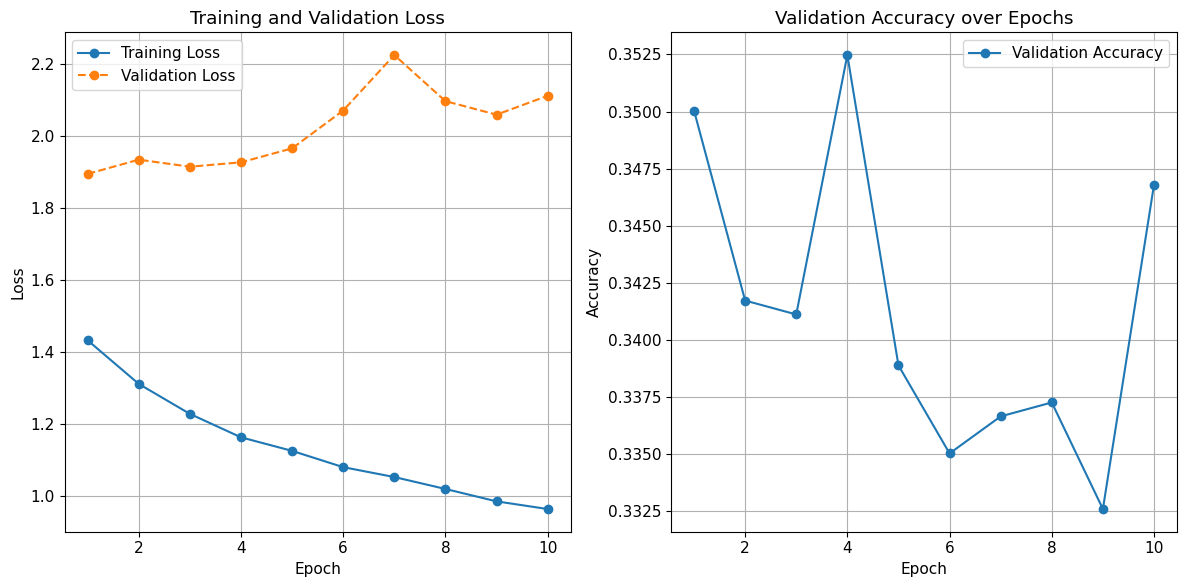

In [12]:
%matplotlib inline
# Plot Training and Validation Losses
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy', marker='o', color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Display both plots
plt.tight_layout()
plt.show()

In [13]:
finetune_test_dataset = RefCOCOgDataset(transform=preprocess, split='test', crop=True)

batch_size = 64
shuffle = True
num_workers = 4
pin_memory = True
persistent_workers = True

finetune_test_loader = DataLoader(
    dataset=finetune_test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

test_loss, test_accuracy = validate(clip_model, finetune_test_loader, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Val Loss: 0.0016 | Val Accuracy: 1.0000: 100%|██████████| 151/151 [00:50<00:00,  3.01it/s]

Test Loss: 1.6852
Test Accuracy: 0.5297


# Models 

## New Train/validation/test splits

Since the goal of this model is to predict bounding boxes of an object in a picture from a textual description, new Dataset classes are created that do notapply any  crop or transformation to the images

In [ ]:
# Train, test, and validation set split cropping images, without applying any transformation 
train_dataset = RefCOCOgDataset(split='train')
val_dataset = RefCOCOgDataset(split='val')
test_dataset = RefCOCOgDataset(split='test')

# DataLoaders batch size and other options. Computation is done with 4 workers to speed it up
batch_size = 64
shuffle = True
num_workers = 4
pin_memory = True
persistent_workers = True

# DataLoader, to create iterable batches with 32 examples each, shuffled in case of training set and not shuffled in case of test and validation sets
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

print("=======================================================")
print("Number of training samples:",len(train_dataset))
print("Number of validation samples:",len(val_dataset))
print("Number of test samples:",len(test_dataset))
print("=======================================================")

## 1. Base Model

### Model definition

The base model is defined as a starting point to further study the task and become familiar with this visual grounding task.\
The approach is described in the project statement and is useful to get familiar with the visual grounding task. \
The idea is to feed the image inside YOLO to get the bounding boxes of all objects, apply to each the preprocessing and the find using clip the one that is the most close to the tokenizewd textual description. \
to find the object the closest to the description, the cosine similarity measure is used.

In [14]:
class BaseModel(nn.Module):
    # The constructor takes as input the YOLO and CLIP models, the confidence treshold for the object recognition and the transform preprocess to appply to each object
    def __init__(self, yolo_model, clip_model, confidence_threshold = 0.5, transform = None, device = "cuda"):
        super().__init__()
        # Initialize class' variables
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.transform = transform

        # Initialize class' models
        self.yolo_model = yolo_model
        self.clip_model = clip_model
        self.yolo_model.to(device)
        self.clip_model.to(device)

    def forward(image, description):

        image = image.to(device, non_blocking=True)
        description = clip.tokenize(description).to(device, non_blocking=True)

        # Get all objects with YOLO inference
        yolo_results = self.yolo_model(image, conf=self.confidence_thresholdi)
        # results.print()

        # Extract bounding boxes and crop the image into multiple objects' images
        yolo_results = yolo_results.xyxy[0]
        objects = []
        for result in yolo_results:
            x1, y1, x2, y2, confidence, class_id = result.tolist()

            # Crop image and apply transformation for CLIP
            cropped_image = image.crop((x1, y1, x2, y2))
            if self.transform:
                cropped_image = self.transform(cropped_image)

            # Append to the array of images
            objects.append(cropped_image)

        # Get description embedding
        description_tokenized = clip_model.tokenize(description).to(self.device)
        description_embedding = self.clip_model.encode_text(description_tokenized).float()

        # Get objects images embeddings
        objects_embeddings = []
        for obj in objects:
            obj = obj.to(self.device)
            object_embedding = self.clip_model.encode_image(obj).float()
            objects_embeddings.append(object_embedding)

        # Calculating similarities between text and images
        similarities = []
        for object_embedding in objects_embeddings:
            similarity = torch.cosine_similarity(object_embedding, description_embedding, dim=-1)
            similarities.append(similarity.item())

        # Find best similarity
        best_match_index = torch.argmax(torch.tensor(similarities))
        best_match_bbox = yolo_results[best_match_index][:4]
        best_match_score = similarities[best_match_index]

        # Return the best score
        return best_match_bbox, best_match_score


### Train/ValidationTest functions

The loss function used to train the model is the IoU (Intersection over Union), 

In [15]:
def train_epoch(model,
                train_loader,
                criterion,
                optimizer,
                device):

    
    model.train()
    total_loss = 0
    total_iou = 0
    total_samples = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for batch in pbar:
        # Get batch data
        images = batch['image'].to(device, non_blocking=True)
        sentences = batch['sentence']
        target_boxes = batch['bbox'].to(device, non_blocking=True)
        
        # Forward pass
        pred_boxes, similarity_scores = model(images, sentences)
        
        # Calculate loss
        loss = criterion(pred_boxes, target_boxes, similarity_scores)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        batch_size = images.size(0)
        total_samples += batch_size
        total_loss += loss.item() * batch_size
        
        # Calculate IoU
        ious = calculate_iou(pred_boxes, target_boxes)
        total_iou += ious.sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{total_loss/total_samples:.4f}',
            'iou': f'{total_iou/total_samples:.4f}'
        })
    
    return {
        'loss': total_loss / total_samples,
        'iou': total_iou / total_samples
    }


def validate(model, 
            val_loader, 
            criterion,
            device):
 
    model.eval()
    total_loss = 0
    total_iou = 0
    total_samples = 0
    
    pbar = tqdm(val_loader, desc="Validating")
    for batch in pbar:
        # Get batch data
        images = batch['image'].to(device, non_blocking=True)
        sentences = batch['sentence']
        target_boxes = batch['bbox'].to(device, non_blocking=True)
        
        # Forward pass
        pred_boxes, similarity_scores = model(images, sentences)
        
        # Calculate loss
        loss = criterion(pred_boxes, target_boxes, similarity_scores)
        
        # Calculate metrics
        batch_size = images.size(0)
        total_samples += batch_size
        total_loss += loss.item() * batch_size
        
        # Calculate IoU
        ious = calculate_iou(pred_boxes, target_boxes)
        total_iou += ious.sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{total_loss/total_samples:.4f}',
            'iou': f'{total_iou/total_samples:.4f}'
        })
    
    return {
        'loss': total_loss / total_samples,
        'iou': total_iou / total_samples
    }


def test(model, 
         test_loader, 
         device):
    
    model.eval()
    total_iou = 0
    total_samples = 0
    all_ious = []
    
    pbar = tqdm(test_loader, desc="Testing")
    for batch in pbar:
        # Get batch data
        images = batch['image'].to(device, non_blocking=True)
        sentences = batch['sentence']
        target_boxes = batch['bbox'].to(device, non_blocking=True)
        
        # Forward pass
        pred_boxes, similarity_scores = model(images, sentences)
        
        # Calculate IoU
        ious = calculate_iou(pred_boxes, target_boxes)
        all_ious.extend(ious.cpu().numpy())
        
        # Update totals
        batch_size = images.size(0)
        total_samples += batch_size
        total_iou += ious.sum().item()
        
        # Update progress bar
        pbar.set_postfix({'iou': f'{total_iou/total_samples:.4f}'})
    
    all_ious = np.array(all_ious)
    return {
        'mean_iou': total_iou / total_samples,
        'iou_50': (all_ious > 0.5).mean(),
        'iou_75': (all_ious > 0.75).mean()
    }

def calculate_iou(pred_boxes: torch.Tensor, target_boxes: torch.Tensor) -> torch.Tensor:

    # Convert from [x, y, w, h] to [x1, y1, x2, y2]
    pred_x1 = pred_boxes[:, 0]
    pred_y1 = pred_boxes[:, 1]
    pred_x2 = pred_boxes[:, 0] + pred_boxes[:, 2]
    pred_y2 = pred_boxes[:, 1] + pred_boxes[:, 3]
    
    target_x1 = target_boxes[:, 0]
    target_y1 = target_boxes[:, 1]
    target_x2 = target_boxes[:, 0] + target_boxes[:, 2]
    target_y2 = target_boxes[:, 1] + target_boxes[:, 3]
    
    # Calculate intersection
    x1 = torch.max(pred_x1, target_x1)
    y1 = torch.max(pred_y1, target_y1)
    x2 = torch.min(pred_x2, target_x2)
    y2 = torch.min(pred_y2, target_y2)
    
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    
    # Calculate union
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    target_area = (target_x2 - target_x1) * (target_y2 - target_y1)
    union = pred_area + target_area - intersection
    
    return intersection / (union + 1e-6)

Instantiating and evaluating the model

## 2. XGBoost integration (?)

After fine-tuning Clip and evaluating the base model, a custom model is defined for the project.

# Notes on what to do 

Things to consider when implementing the custom model are:
 - Data augmentation (increase the size of the dataset by applying transformations to the images)
 - Regularization techniques
 - Hyperparameters tuning (partially done in the fine-tuning part, as different values of learning rate have been tested)

Evaluation is done on measures like:
 - localization accuracy
 - grounding accuracy
 - semantic similarity